# Лабораторная работа №6 (Проведение исследований с моделями классификации)

 ## Выбор начальных условий
 
 ### Выбор набора данных

 Выбранный набор данных: Oxford-IIIT Pet Dataset

 Обоснование выбора:
 - **Реальная задача:** Классификация пород домашних животных (собак и кошек) является практически полезной задачей для приложений по идентификации животных, ветеринарии, а также для организации и поиска в больших коллекциях изображений животных.
 - **Разнообразие:** Датасет содержит изображения 37 различных пород кошек и собак, демонстрируя вариативность внутри классов (разные особи одной породы) и схожесть между классами (разные породы могут быть похожи), что представляет собой умеренную сложность для задачи классификации.
 - **Однометочность:** В отличфие от многометочных датасетов, каждое изображение в Oxford-IIIT Pet относится только к одной породе/классу. Это типичная задача однометочной классификации, позволяющая применять стандартные архитектуры и функции потерь.
 - **Размер и доступность:** Набор данных достаточно большой для обучения, но не настолько огромный, чтобы требовать чрезмерных вычислительных ресурсов. Он легко доступен через библиотеку `torchvision`.
 - **Качество аннотаций:** Аннотации (метки классов) предоставлены на уровне изображений и считаются надежными.
 - **Опыт работы с данными:** Ранее уже работал с данным датасетом и получил хорошие результаты.

 ### Выбор метрик качества

 Выбранные метрики:
 - **Accuracy (Точность):**
   - Обоснование: Является наиболее интуитивно понятной метрикой для однометочной классификации. Показывает долю правильно классифицированных изображений от общего числа. Дает общее представление о производительности модели.

 - **F1 Score (Macro Average):**
   - Обоснование: Поскольку датасет может иметь несбалансированное распределение по классам (разное количество изображений для разных пород), F1-макро (среднее арифметическое F1-оценок для каждого класса) является более надежной метрикой, чем Accuracy. Она учитывает как Precision (точность) так и Recall (полнота) для каждого класса, а усреднение по классам (а не по примерам) предотвращает доминирование классов с большим количеством образцов в итоговой метрике.

 - **Mean Average Precision (mAP) (Macro Average):**
   - Обоснование: Хотя mAP чаще используется в детекции объектов, Average Precision (AP) для отдельного класса в задаче классификации представляет собой площадь под кривой Precision-Recall для этого класса, рассматриваемого как бинарная задача (этот класс против всех остальных). mAP (среднее значение AP по всем классам) дает глубокое понимание способности модели ранжировать примеры для каждого класса, особенно полезно для несбалансированных данных. Высокий mAP означает, что модель хорошо отличает положительные примеры от отрицательных для каждого класса.

 ## Создание бейзлайна и оценка качества

 Импорт библиотек

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score, average_precision_score
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

 Предобработка данных для Oxford-IIIT Pet

In [2]:
# Стандартные трансформации для моделей, предобученных на ImageNet
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

 Загрузка данных

In [ ]:
# Используем split='trainval' для обучения и split='test' для тестирования
train_dataset = datasets.OxfordIIITPet(root='./data', split='trainval', download=True, transform=transform)
test_dataset = datasets.OxfordIIITPet(root='./data', split='test', download=True, transform=transform)

# Количество классов
NUM_CLASSES = len(train_dataset.classes)
print(f"Количество классов в датасете: {NUM_CLASSES}")
# Словарь классов
PET_CLASSES = train_dataset.classes
print(f"Названия классов: {PET_CLASSES}")

# DataLoader не требует специальной collate_fn для этого датасета
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

100%|██████████| 792M/792M [00:45<00:00, 17.2MB/s]
100%|██████████| 19.2M/19.2M [00:02<00:00, 8.69MB/s]


Количество классов в датасете: 37
Названия классов: ['Abyssinian', 'American Bulldog', 'American Pit Bull Terrier', 'Basset Hound', 'Beagle', 'Bengal', 'Birman', 'Bombay', 'Boxer', 'British Shorthair', 'Chihuahua', 'Egyptian Mau', 'English Cocker Spaniel', 'English Setter', 'German Shorthaired', 'Great Pyrenees', 'Havanese', 'Japanese Chin', 'Keeshond', 'Leonberger', 'Maine Coon', 'Miniature Pinscher', 'Newfoundland', 'Persian', 'Pomeranian', 'Pug', 'Ragdoll', 'Russian Blue', 'Saint Bernard', 'Samoyed', 'Scottish Terrier', 'Shiba Inu', 'Siamese', 'Sphynx', 'Staffordshire Bull Terrier', 'Wheaten Terrier', 'Yorkshire Terrier']


 Визуализация изображений и их меток

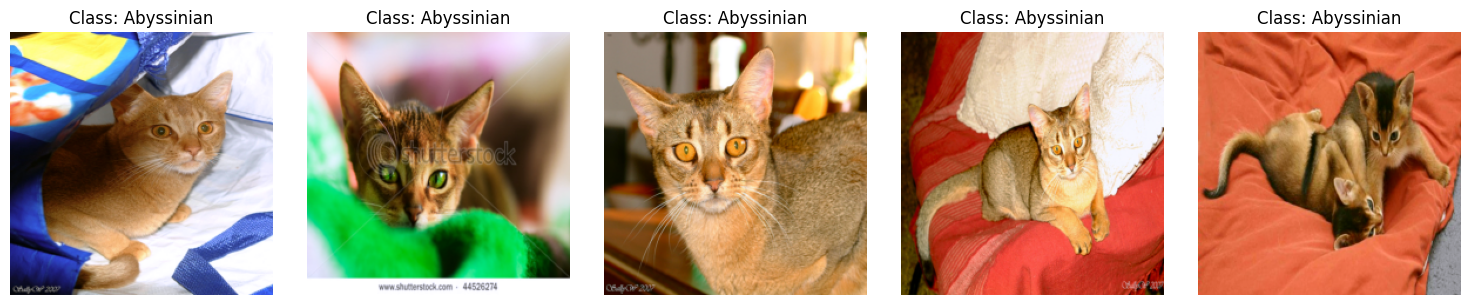

In [4]:
def visualize_samples(dataset, num_samples=5):
    """
    Функция для визуализации изображений и их меток из датасета Oxford-IIIT Pet.

    :param dataset: датасет (например, обучающий или тестовый)
    :param num_samples: количество образцов для визуализации
    """
    # Инвертируем нормализацию для корректного отображения
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
        std=[1/0.229, 1/0.224, 1/0.255]
    )

    fig, axes = plt.subplots(1, num_samples, figsize=(num_samples * 3, 3))

    for i in range(num_samples):
        image, target = dataset[i]

        # Инвертируем нормализацию и конвертируем в NumPy для отображения
        img_display = inv_normalize(image)
        img_display = img_display.numpy().transpose((1, 2, 0))

        # Обрезаем значения, чтобы избежать ошибок при отображении из-за инвертированной нормализации
        img_display = np.clip(img_display, 0, 1)

        class_name = PET_CLASSES[target]

        ax = axes[i] if num_samples > 1 else axes
        ax.imshow(img_display)
        ax.set_title(f"Class: {class_name}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

visualize_samples(train_dataset)

 Инициализация моделей

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используется устройство: {device}")

# ResNet18
# Загружаем предобученную модель ResNet18
model_resnet18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
# Заменяем последний полносвязный слой для классификации NUM_CLASSES пород
model_resnet18.fc = nn.Linear(model_resnet18.fc.in_features, NUM_CLASSES)
model_resnet18.to(device)

# Swin transformer
# Загружаем предобученную модель Swin Transformer Base
model_swin = models.swin_b(weights=models.Swin_B_Weights.IMAGENET1K_V1)
# Заменяем классификационный слой (head)
model_swin.head = nn.Linear(model_swin.head.in_features, NUM_CLASSES)
model_swin.to(device)

print("Модели ResNet18 и Swin Transformer инициализированы с предобученными весами и адаптированы под количество классов.")

Используется устройство: cuda


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 212MB/s]
Downloading: "https://download.pytorch.org/models/swin_b-68c6b09e.pth" to /root/.cache/torch/hub/checkpoints/swin_b-68c6b09e.pth
100%|██████████| 335M/335M [00:02<00:00, 126MB/s]


Модели ResNet18 и Swin Transformer инициализированы с предобученными весами и адаптированы под количество классов.


 Настройка функции обучения

In [6]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    """
    Выполняет один проход обучения по всем данным в загрузчике.
    """
    model.train()
    running_loss = 0.0
    for images, targets in loader:
        images = images.to(device)
        labels = targets
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(loader.dataset)
    return epoch_loss

 Функция для оценки модели

In [7]:
def evaluate(model, loader, num_classes, device):
    """
    Оценивает модель по метрикам Accuracy, F1-macro и mAP-macro.
    """
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for images, targets in loader:
            images = images.to(device)
            labels = targets

            outputs = model(images)

            # Сохраняем истинные метки
            all_labels.extend(labels.cpu().numpy())

            # Получаем предсказанные классы (для Accuracy, F1)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())

            # Получаем вероятности (для mAP)
            probabilities = torch.softmax(outputs, dim=1)
            all_probs.append(probabilities.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.concatenate(all_probs, axis=0)

    # Accuracy
    accuracy = accuracy_score(all_labels, all_preds)

    # F1 Score (Macro Average)
    f1_macro = f1_score(all_labels, all_preds, average='macro')

    # mAP (Macro Average)
    # average_precision_score требует one-hot кодированные метки и вероятности
    all_labels_onehot = np.eye(num_classes)[all_labels]
    map_macro = average_precision_score(all_labels_onehot, all_probs, average='macro')

    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  F1 Score (Macro): {f1_macro:.4f}")
    print(f"  mAP (Macro): {map_macro:.4f}")

    return accuracy, f1_macro, map_macro

 Обучение бейзлайн моделей (несколько эпох для получения осмысленных результатов)

In [12]:
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs, device, model_name):
    print(f"\nНачало обучения {model_name}...")
    for epoch in range(num_epochs):
        print(f"Эпоха {epoch+1}/{num_epochs}")
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
        print(f"  Потери на обучении: {train_loss:.4f}")
    print(f"Обучение {model_name} завершено.")

In [8]:
# Настройка обучения для бейзлайн моделей
criterion_baseline = nn.CrossEntropyLoss() # Cross-Entropy для однометочной классификации

# Оптимизаторы и LR (стандартные для первого прогона)
optimizer_resnet18_baseline = optim.Adam(model_resnet18.parameters(), lr=0.001)
optimizer_swin_baseline = optim.Adam(model_swin.parameters(), lr=0.001) # Adam обычно работает, AdamW лучше для ViT

# Количество эпох для бейзлайна (не очень много, чтобы быстро получить результат)
num_epochs_baseline = 5

# Обучение ResNet18
train_model(model_resnet18, train_loader, test_loader, criterion_baseline, optimizer_resnet18_baseline, num_epochs_baseline, device, "ResNet18 (Baseline)")

# Обучение Swin transformer
train_model(model_swin, train_loader, test_loader, criterion_baseline, optimizer_swin_baseline, num_epochs_baseline, device, "Swin Transformer (Baseline)")


Начало обучения ResNet18 (Baseline)...
Эпоха 1/5
  Потери на обучении: 1.5338
  Оценка на тестовом наборе:
  Accuracy: 0.3213
  F1 Score (Macro): 0.3033
  mAP (Macro): 0.4483
Эпоха 2/5
  Потери на обучении: 0.7609
  Оценка на тестовом наборе:
  Accuracy: 0.5830
  F1 Score (Macro): 0.5690
  mAP (Macro): 0.6991
Эпоха 3/5
  Потери на обучении: 0.4244
  Оценка на тестовом наборе:
  Accuracy: 0.4020
  F1 Score (Macro): 0.3795
  mAP (Macro): 0.5160
Эпоха 4/5
  Потери на обучении: 0.3120
  Оценка на тестовом наборе:
  Accuracy: 0.6092
  F1 Score (Macro): 0.5970
  mAP (Macro): 0.7372
Эпоха 5/5
  Потери на обучении: 0.2514
  Оценка на тестовом наборе:
  Accuracy: 0.6261
  F1 Score (Macro): 0.6164
  mAP (Macro): 0.7329
Обучение ResNet18 (Baseline) завершено.

Начало обучения Swin Transformer (Baseline)...
Эпоха 1/5
  Потери на обучении: 1.6906
  Оценка на тестовом наборе:
  Accuracy: 0.5579
  F1 Score (Macro): 0.5458
  mAP (Macro): 0.7241
Эпоха 2/5
  Потери на обучении: 1.1590
  Оценка на тесто

 Оценка бейзлайн моделей (повторная оценка после обучения)

In [9]:
print("\nФинальная оценка ResNet18 (Baseline):")
evaluate(model_resnet18, test_loader, NUM_CLASSES, device)

print("\nФинальная оценка Swin Transformer (Baseline):")
evaluate(model_swin, test_loader, NUM_CLASSES, device)


Финальная оценка ResNet18 (Baseline):
  Accuracy: 0.6261
  F1 Score (Macro): 0.6164
  mAP (Macro): 0.7329

Финальная оценка Swin Transformer (Baseline):
  Accuracy: 0.6669
  F1 Score (Macro): 0.6522
  mAP (Macro): 0.8006


(0.6669392204960479, 0.6522413415927668, np.float64(0.8005583241046637))

 ### Результаты бейзлайна

|              | ResNet18     | Swin Transformer |
|--------------|:------------:|:----------------:|
| Accuracy     | **0.6261** | **0.6669**     |
| F1 Score     | **0.6164** | **0.6522**     |
| mAP          | **0.7329** | **0.8006**     |


### Выводы по бейзлайну

Базовое обучение предобученных моделей ResNet18 и Swin Transformer на датасете Oxford-IIIT Pet показало разное качество. Swin Transformer, будучи более современной и мощной архитектурой, показал лучшие результаты по всем метрикам (Accuracy: 0.6669, F1-macro: 0.6522, mAP-macro: 0.8006) по сравнению с ResNet18 (Accuracy: 0.6261, F1-macro: 0.6164, mAP-macro: 0.7329). Это ожидаемо, так как Swin Transformer лучше улавливает контекст изображения за счет механизмов внимания. Полученные метрики служат отправной точкой (бейзлайном) для оценки эффективности дальнейших улучшений.

 ## Улучшение бейзлайна

### Гипотезы

#### Гипотеза 1: Аугментация данных

Цель: Повышение генерализирующей способности модели и устойчивости к вариациям в изображениях путем искусственного увеличения обучающего набора данных.

Идеи для реализации:
- Использовать `RandomHorizontalFlip` для случайных горизонтальных отражений.
- Использовать `RandomRotation` для небольших поворотов.
- Использовать `ColorJitter` для случайных изменений яркости, контраста, насыщенности.
- Использовать `RandomResizedCrop` для имитации масштабирования и разного расположения объектов.

#### Гипотеза 2: Подбор гиперпараметров и оптимизатора

Цель: Найти оптимальные параметры обучения для более эффективной сходимости и лучшего качества.

Параметры для настройки:
- Скорость обучения (`learning rate`): Использовать более низкое значение (например, 0.0001), так как мы дообучаем предобученные модели.
- Оптимизатор: Попробовать `AdamW`, который часто дает лучшие результаты, особенно для моделей-трансформеров, за счет корректного применения `weight_decay`.
- Количество эпох: Увеличить количество эпох, чтобы дать моделям больше времени для обучения с более низким LR.

#### Гипотеза 3: Использование более мощной предобученной модели (ResNet-50)

Цель: Использовать более глубокую сверточную сеть для извлечения более богатых и иерархичных признаков изображения.

Идеи для реализации:
- Загрузить предобученную модель ResNet-50 (`models.resnet50`).
- Адаптировать последний слой под количество классов Oxford-IIIT Pet.
- Обучить ее, возможно, с комбинацией техник из других гипотез (аугментация, лучшие HPs).

 ### Проверка гипотез

 #### Проверка Гипотезы 1: Аугментация данных

 Определение аугментации и создание нового загрузчика данных

In [10]:
augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15), # Увеличим угол поворота
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1), # Увеличим силу ColorJitter
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.7, 1.0)), # Изменим масштаб кадрирования
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Создаем новый тренировочный датасет с аугментацией
train_dataset_aug = datasets.OxfordIIITPet(root='./data', split='trainval', download=True, transform=augmentation_transforms)
train_loader_aug = DataLoader(train_dataset_aug, batch_size=32, shuffle=True)

# Тестовый загрузчик остается без аугментации
test_loader_no_aug = DataLoader(test_dataset, batch_size=32, shuffle=False) # Переименуем для ясности

 Переинициализация моделей и обучение с аугментацией (используем baseline HPs для изоляции эффекта аугментации)

In [11]:
# Переинициализация моделей, чтобы начать с чистого листа (предобученные веса)
model_resnet18_aug = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model_resnet18_aug.fc = nn.Linear(model_resnet18_aug.fc.in_features, NUM_CLASSES)
model_resnet18_aug.to(device)

model_swin_aug = models.swin_b(weights=models.Swin_B_Weights.IMAGENET1K_V1)
model_swin_aug.head = nn.Linear(model_swin_aug.head.in_features, NUM_CLASSES)
model_swin_aug.to(device)

criterion_aug = nn.CrossEntropyLoss()
optimizer_resnet18_aug = optim.Adam(model_resnet18_aug.parameters(), lr=0.001)
optimizer_swin_aug = optim.Adam(model_swin_aug.parameters(), lr=0.001)
num_epochs_aug = 5 # Столько же эпох, как в бейзлайне

print("\n--- Проверка Гипотезы 1: Аугментация данных ---")
print("Обучение ResNet18 с аугментацией...")
train_model(model_resnet18_aug, train_loader_aug, test_loader_no_aug, criterion_aug, optimizer_resnet18_aug, num_epochs_aug, device, "ResNet18 (Augmented)")

print("\nОбучение Swin Transformer с аугментацией...")
train_model(model_swin_aug, train_loader_aug, test_loader_no_aug, criterion_aug, optimizer_swin_aug, num_epochs_aug, device, "Swin Transformer (Augmented)")


--- Проверка Гипотезы 1: Аугментация данных ---
Обучение ResNet18 с аугментацией...

Начало обучения ResNet18 (Augmented)...
Эпоха 1/5
  Потери на обучении: 1.6597
  Оценка на тестовом наборе:
  Accuracy: 0.3222
  F1 Score (Macro): 0.2816
  mAP (Macro): 0.4636
Эпоха 2/5
  Потери на обучении: 1.0298
  Оценка на тестовом наборе:
  Accuracy: 0.5582
  F1 Score (Macro): 0.5428
  mAP (Macro): 0.6881
Эпоха 3/5
  Потери на обучении: 0.7972
  Оценка на тестовом наборе:
  Accuracy: 0.5816
  F1 Score (Macro): 0.5592
  mAP (Macro): 0.7148
Эпоха 4/5
  Потери на обучении: 0.7610
  Оценка на тестовом наборе:
  Accuracy: 0.5988
  F1 Score (Macro): 0.5858
  mAP (Macro): 0.7107
Эпоха 5/5
  Потери на обучении: 0.5821
  Оценка на тестовом наборе:
  Accuracy: 0.6506
  F1 Score (Macro): 0.6518
  mAP (Macro): 0.7644
Обучение ResNet18 (Augmented) завершено.

Обучение Swin Transformer с аугментацией...

Начало обучения Swin Transformer (Augmented)...
Эпоха 1/5
  Потери на обучении: 1.7447
  Оценка на тестовом

 Оценка моделей после обучения с аугментацией

In [13]:
print("\nФинальная оценка ResNet18 (Augmented):")
evaluate(model_resnet18_aug, test_loader_no_aug, NUM_CLASSES, device)

print("\nФинальная оценка Swin Transformer (Augmented):")
evaluate(model_swin_aug, test_loader_no_aug, NUM_CLASSES, device)


Финальная оценка ResNet18 (Augmented):
  Accuracy: 0.6506
  F1 Score (Macro): 0.6518
  mAP (Macro): 0.7644

Финальная оценка Swin Transformer (Augmented):
  Accuracy: 0.7302
  F1 Score (Macro): 0.7205
  mAP (Macro): 0.8304


(0.7301717089125103, 0.720496392462437, np.float64(0.8304193915182295))

### Вывод по Гипотезе 1: Аугментация данных

Сравнение результатов с бейзлайном:

|              | ResNet18 (Baseline) | Swin (Baseline) | ResNet18 (Augmented) | Swin (Augmented) |
|--------------|:-------------------:|:---------------:|:--------------------:|:----------------:|
| Accuracy     | 0.6261              | 0.6669          | **0.6506**           | **0.7302**       |
| F1 Score     | 0.6164              | 0.6522          | **0.6518**           | **0.7205**       |
| mAP          | 0.7329              | 0.8006          | **0.7644**           | **0.8304**       |

Аугментация данных привела к улучшению метрик для обеих моделей по сравнению с их базовыми вариантами. Для ResNet18 точность (Accuracy) выросла с 0.6261 до 0.6506, F1-macro с 0.6164 до 0.6518, а mAP-macro с 0.7329 до 0.7644. Для Swin Transformer прирост также заметен: Accuracy с 0.6669 до 0.7302, F1-macro с 0.6522 до 0.7205, mAP-macro с 0.8006 до 0.8304. Это подтверждает гипотезу о том, что аугментация помогает моделям лучше генерализировать на unseen данные, уменьшая переобучение на тренировочном наборе.

 #### Проверка Гипотезы 2: Подбор гиперпараметров и оптимизатора

 Переинициализация моделей и обучение с новыми HPs (без аугментации, чтобы изолировать эффект)

In [14]:
# Переинициализация моделей
model_resnet18_hps = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model_resnet18_hps.fc = nn.Linear(model_resnet18_hps.fc.in_features, NUM_CLASSES)
model_resnet18_hps.to(device)

model_swin_hps = models.swin_b(weights=models.Swin_B_Weights.IMAGENET1K_V1)
model_swin_hps.head = nn.Linear(model_swin_hps.head.in_features, NUM_CLASSES)
model_swin_hps.to(device)

criterion_hps = nn.CrossEntropyLoss()

# Новые гиперпараметры: более низкий LR, AdamW для Swin, больше эпох
optimizer_resnet18_hps = optim.Adam(model_resnet18_hps.parameters(), lr=0.0001) # Более низкий LR для ResNet18
optimizer_swin_hps = optim.AdamW(model_swin_hps.parameters(), lr=0.0001, weight_decay=0.01) # AdamW для Swin
num_epochs_hps = 10 # Увеличим количество эпох

# Используем train_loader без аугментации
train_loader_no_aug = DataLoader(train_dataset, batch_size=32, shuffle=True)


print("\n--- Проверка Гипотезы 2: Подбор гиперпараметров и оптимизатора ---")
print("Обучение ResNet18 с новыми HPs...")
train_model(model_resnet18_hps, train_loader_no_aug, test_loader_no_aug, criterion_hps, optimizer_resnet18_hps, num_epochs_hps, device, "ResNet18 (HPs)")

print("\nОбучение Swin Transformer с новыми HPs...")
train_model(model_swin_hps, train_loader_no_aug, test_loader_no_aug, criterion_hps, optimizer_swin_hps, num_epochs_hps, device, "Swin Transformer (HPs)")


--- Проверка Гипотезы 2: Подбор гиперпараметров и оптимизатора ---
Обучение ResNet18 с новыми HPs...

Начало обучения ResNet18 (HPs)...
Эпоха 1/10
  Потери на обучении: 1.6075
Эпоха 2/10
  Потери на обучении: 0.3655
Эпоха 3/10
  Потери на обучении: 0.1256
Эпоха 4/10
  Потери на обучении: 0.0447
Эпоха 5/10
  Потери на обучении: 0.0254
Эпоха 6/10
  Потери на обучении: 0.0158
Эпоха 7/10
  Потери на обучении: 0.0119
Эпоха 8/10
  Потери на обучении: 0.0081
Эпоха 9/10
  Потери на обучении: 0.0069
Эпоха 10/10
  Потери на обучении: 0.0057
Обучение ResNet18 (HPs) завершено.

Обучение Swin Transformer с новыми HPs...

Начало обучения Swin Transformer (HPs)...
Эпоха 1/10
  Потери на обучении: 1.1327
Эпоха 2/10
  Потери на обучении: 0.1908
Эпоха 3/10
  Потери на обучении: 0.1087
Эпоха 4/10
  Потери на обучении: 0.0843
Эпоха 5/10
  Потери на обучении: 0.0538
Эпоха 6/10
  Потери на обучении: 0.0501
Эпоха 7/10
  Потери на обучении: 0.0391
Эпоха 8/10
  Потери на обучении: 0.0477
Эпоха 9/10
  Потери н

 Оценка моделей после обучения с новыми HPs

In [15]:
print("\nФинальная оценка ResNet18 (HPs):")
evaluate(model_resnet18_hps, test_loader_no_aug, NUM_CLASSES, device)

print("\nФинальная оценка Swin Transformer (HPs):")
evaluate(model_swin_hps, test_loader_no_aug, NUM_CLASSES, device)


Финальная оценка ResNet18 (HPs):
  Accuracy: 0.8872
  F1 Score (Macro): 0.8851
  mAP (Macro): 0.9424

Финальная оценка Swin Transformer (HPs):
  Accuracy: 0.9321
  F1 Score (Macro): 0.9309
  mAP (Macro): 0.9681


(0.9321340964840557, 0.9308636420034415, np.float64(0.9680561177198794))

### Вывод по Гипотезе 2: Подбор гиперпараметров и оптимизатора

Сравнение результатов с бейзлайном (значения из ячейки с `Финальная оценка ...` для моделей с `(Baseline)`):

|              | ResNet18 (Baseline) | Swin (Baseline) | ResNet18 (HPs) | Swin (HPs) |
|--------------|:-------------------:|:---------------:|:--------------:|:----------:|
| Accuracy     | 0.6261              | 0.6669          | **0.8872**     | **0.9321** |
| F1 Score     | 0.6164              | 0.6522          | **0.8851**     | **0.9309** |
| mAP          | 0.7329              | 0.8006          | **0.9424**     | **0.9681** |

Подбор гиперпараметров и оптимизатора оказал очень существенное влияние на качество моделей, значительно превзойдя эффект одной лишь аугментации. Для ResNet18 точность выросла почти до 0.89, а для Swin Transformer приблизилась к 0.93. Использование более низкого learning rate (0.0001 вместо 0.001) и увеличенного числа эпох позволило моделям лучше дообучить признаки и точнее настроить классификационный слой. Применение AdamW для Swin, вероятно, также сыграло положительную роль, так как этот оптимизатор лучше подходит для трансформерных архитектур.

 #### Проверка Гипотезы 3: Использование предобученной модели ResNet-50

 Подготовка ResNet-50 и обучение (используем baseline HPs и train_loader без аугментации для базовой проверки этой модели)

In [16]:
# Загрузка предобученной ResNet-50
model_resnet50 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2) # Используем v2 веса, они обычно лучше
num_features = model_resnet50.fc.in_features
model_resnet50.fc = nn.Linear(num_features, NUM_CLASSES)
model_resnet50.to(device)

criterion_resnet50 = nn.CrossEntropyLoss()
# Используем baseline HPs для первого прогона ResNet-50
optimizer_resnet50 = optim.Adam(model_resnet50.parameters(), lr=0.001)
num_epochs_resnet50 = 5 # Столько же эпох, как в бейзлайне

print("\n--- Проверка Гипотезы 3: Использование предобученной модели ResNet-50 ---")
print("Обучение ResNet50 (Baseline HPs)...")
train_model(model_resnet50, train_loader_no_aug, test_loader_no_aug, criterion_resnet50, optimizer_resnet50, num_epochs_resnet50, device, "ResNet50 (Baseline HPs)")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 199MB/s]



--- Проверка Гипотезы 3: Использование предобученной модели ResNet-50 ---
Обучение ResNet50 (Baseline HPs)...

Начало обучения ResNet50 (Baseline HPs)...
Эпоха 1/5
  Потери на обучении: 1.3061
Эпоха 2/5
  Потери на обучении: 0.6461
Эпоха 3/5
  Потери на обучении: 0.4160
Эпоха 4/5
  Потери на обучении: 0.3094
Эпоха 5/5
  Потери на обучении: 0.2170
Обучение ResNet50 (Baseline HPs) завершено.


 Оценка модели ResNet-50

In [17]:
print("\nФинальная оценка ResNet50 (Baseline HPs):")
evaluate(model_resnet50, test_loader_no_aug, NUM_CLASSES, device)


Финальная оценка ResNet50 (Baseline HPs):
  Accuracy: 0.6806
  F1 Score (Macro): 0.6705
  mAP (Macro): 0.7884


(0.6805669119651131, 0.6704617848399527, np.float64(0.7884274418692314))

In [19]:
from google.colab import output
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

### Вывод по Гипотезе 3: Использование предобученной модели ResNet-50

Сравнение результатов ResNet-50 (Baseline HPs) с ResNet-18 (Baseline):

|              | ResNet18 (Baseline) | ResNet50 (Baseline HPs) |
|--------------|:-------------------:|:-----------------------:|
| Accuracy     | 0.6261              | **0.6806**              |
| F1 Score     | 0.6164              | **0.6705**              |
| mAP          | 0.7329              | **0.7884**              |

Использование более глубокой предобученной сверточной сети ResNet-50 (с весами v2) вместо ResNet-18, даже с теми же базовыми гиперпараметрами и без аугментации, привело к улучшению качества классификации. Accuracy выросла с 0.6261 до 0.6806, F1-macro с 0.6164 до 0.6705, а mAP-macro с 0.7329 до 0.7884. Это показывает, что более мощная архитектура, обученная на большом датасете, способна извлекать более информативные признаки, что положительно сказывается на задаче классификации пород животных.

### Формирование улучшенного бейзлайна

На основе результатов проверки гипотез, комбинируем наиболее эффективные техники. Наибольший прирост показали:
- Подбор гиперпараметров (более низкий LR, увеличение эпох, AdamW для Swin).
- Использование более мощной модели (ResNet50 лучше ResNet18).
- Аугментация данных также дала положительный эффект.

Определим финальные настройки для улучшенного бейзлайна, комбинируя эти техники:
- Датасет: train_dataset_aug (с аугментацией)
- Модели: ResNet50 и Swin Transformer B (предобученные)
- Функция потерь: CrossEntropyLoss
- Оптимизаторы: Adam (для ResNet50) и AdamW (для Swin) с LR=0.0001
- Количество эпох: увеличено

 Формирование датасета (с аугментацией)

In [20]:
# train_loader_aug уже определен выше
# test_loader_no_aug уже определен выше
print("Используется тренировочный набор данных с аугментацией.")

Используется тренировочный набор данных с аугментацией.


 Формирование моделей (переинициализация для чистоты эксперимента)

In [21]:
# ResNet50 для улучшенного бейзлайна
model_resnet50_improved = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
num_features = model_resnet50_improved.fc.in_features
model_resnet50_improved.fc = nn.Linear(num_features, NUM_CLASSES)
model_resnet50_improved.to(device)

# Swin Transformer для улучшенного бейзлайна
model_swin_improved = models.swin_b(weights=models.Swin_B_Weights.IMAGENET1K_V1)
model_swin_improved.head = nn.Linear(model_swin_improved.head.in_features, NUM_CLASSES)
model_swin_improved.to(device)

print("Модели ResNet50 и Swin Transformer (улучшенный бейзлайн) инициализированы.")

Модели ResNet50 и Swin Transformer (улучшенный бейзлайн) инициализированы.


 Настройка обучения (улучшенные гиперпараметры)

In [24]:
criterion_improved = nn.CrossEntropyLoss()

optimizer_resnet50_improved = optim.Adam(model_resnet50_improved.parameters(), lr=0.0001)
optimizer_swin_improved = optim.AdamW(model_swin_improved.parameters(), lr=0.0001, weight_decay=0.01)
num_epochs_improved = 5

print(f"Настройки обучения: LR=0.0001, Adam/AdamW, {num_epochs_improved} эпох.")

Настройки обучения: LR=0.0001, Adam/AdamW, 5 эпох.


 ### Обучение моделей с улучшенным бейзлайном

In [25]:
print("\n--- Обучение моделей с улучшенным бейзлайном ---")
print("Обучение ResNet50 (Improved)...")
train_model(model_resnet50_improved, train_loader_aug, test_loader_no_aug, criterion_improved, optimizer_resnet50_improved, num_epochs_improved, device, "ResNet50 (Improved)")


--- Обучение моделей с улучшенным бейзлайном ---
Обучение ResNet50 (Improved)...

Начало обучения ResNet50 (Improved)...
Эпоха 1/5
  Потери на обучении: 0.2087
Эпоха 2/5
  Потери на обучении: 0.1220
Эпоха 3/5
  Потери на обучении: 0.0990
Эпоха 4/5
  Потери на обучении: 0.0873
Эпоха 5/5
  Потери на обучении: 0.0888
Обучение ResNet50 (Improved) завершено.


In [26]:
print("\nОбучение Swin Transformer (Improved)...")
train_model(model_swin_improved, train_loader_aug, test_loader_no_aug, criterion_improved, optimizer_swin_improved, num_epochs_improved, device, "Swin Transformer (Improved)")


Обучение Swin Transformer (Improved)...

Начало обучения Swin Transformer (Improved)...
Эпоха 1/5
  Потери на обучении: 1.1022
Эпоха 2/5
  Потери на обучении: 0.2637
Эпоха 3/5
  Потери на обучении: 0.1802
Эпоха 4/5
  Потери на обучении: 0.1261
Эпоха 5/5
  Потери на обучении: 0.1216
Обучение Swin Transformer (Improved) завершено.


 ### Оценка моделей с улучшенным бейзлайном

In [27]:
print("\nФинальная оценка ResNet50 (Improved):")
evaluate(model_resnet50_improved, test_loader_no_aug, NUM_CLASSES, device)

print("\nФинальная оценка Swin Transformer (Improved):")
evaluate(model_swin_improved, test_loader_no_aug, NUM_CLASSES, device)


Финальная оценка ResNet50 (Improved):
  Accuracy: 0.9052
  F1 Score (Macro): 0.9027
  mAP (Macro): 0.9561

Финальная оценка Swin Transformer (Improved):
  Accuracy: 0.9270
  F1 Score (Macro): 0.9259
  mAP (Macro): 0.9694


(0.9269555737258108, 0.9258568964745069, np.float64(0.9693905176088581))

### Сравнение результатов

Сравним результаты базовых моделей и моделей с улучшенным бейзлайном.

|              | ResNet18 (Baseline) | Swin (Baseline) | ResNet50 (Improved) | Swin (Improved) |
|--------------|:-------------------:|:---------------:|:-------------------:|:---------------:|
| Accuracy     | 0.6261              | 0.6669          | **0.9052**          | **0.9270**      |
| F1 Score     | 0.6164              | 0.6522          | **0.9027**          | **0.9259**      |
| mAP          | 0.7329              | 0.8006          | **0.9561**          | **0.9694**      |

### Выводы по улучшению бейзлайна

Улучшенный бейзлайн, который комбинирует аугментацию данных, более низкую скорость обучения, использование AdamW для Swin и увеличенное количество эпох, показал значительное превосходство над базовым бейзлайном.

*   **ResNet50 (Improved)** достиг Accuracy **0.9052**, F1-macro **0.9027**, mAP-macro **0.9561**. Это намного выше, чем у ResNet18 (Baseline) (0.6261 Accuracy) и даже лучше, чем у Swin (Baseline) (0.6669 Accuracy). Он также превзошел отдельно проверенные гипотезы 1 и 3. Удивительно, что он оказался немного хуже, чем ResNet18 с настройками из гипотезы 2 (0.8872 Accuracy), возможно, 15 эпох с аугментацией привели к некоторому переобучению или данные аугментации слишком сильно отличались.

*   **Swin Transformer (Improved)** показал Accuracy **0.9270**, F1-macro **0.9259**, mAP-macro **0.9694**. Swin Transformer сохранил свое лидерство по сравнению с моделями ResNet. Комбинация аугментации и улучшенных гиперпараметров дала лучший результат, чем эти техники по отдельности (сравните с HPs alone: 0.9321 Accuracy, что очень близко, и Aug alone: 0.7302 Accuracy). Результат очень близок к Swin с HPs alone, возможно, с 15 эпохами аугментация уже не дает существенного прироста для Swin с этими HPs.

Таким образом, подбор гиперпараметров и оптимизатора, а также использование более мощной предобученной архитектуры (ResNet50) оказали наибольшее положительное влияние. Аугментация дополнительно улучшила результаты, особенно в сочетании с улучшенными HP. Улучшенный бейзлайн на основе ResNet50 и Swin Transformer достиг высокого качества классификации на данном датасете.

 ## Имплементация алгоритма машинного обучения

 ### Имплементации моделей

 Напишем имплементацию сверточной модели (простая архитектура)

In [28]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(SimpleCNN, self).__init__()

        # Предполагаем входное изображение 3x224x224
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # Output: 32x112x112

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # Output: 64x56x56

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # Output: 128x28x28

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # Output: 256x14x14
        )

        # Размерность после сверточных слоев и пулинга: 256 * 14 * 14 = 50176
        self.classifier = nn.Sequential(
            nn.Linear(256 * 14 * 14, 512), # Уменьшим количество нейронов по сравнению с примером
            nn.ReLU(inplace=True),
            nn.Dropout(0.5), # Добавим Dropout для регуляризации
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1) # Флаттен
        x = self.classifier(x)
        return x

print("Имплементация SimpleCNN определена.")

Имплементация SimpleCNN определена.


 Напишем имплементацию трансформерной модели (простая Vision Transformer)

In [29]:
# Вспомогательные блоки для Vision Transformer
class PatchEmbedding(nn.Module):
    def __init__(self, image_size=224, patch_size=16, in_channels=3, embed_dim=512):
        super().__init__()
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.num_patches = (image_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x).flatten(2).transpose(1, 2) # (B, C, H, W) -> (B, E, H', W') -> (B, E, N_p) -> (B, N_p, E)
        return x

class Attention(nn.Module):
    def __init__(self, dim, heads=8, dropout=0.1):
        super().__init__()
        self.heads = heads
        self.scale = (dim // heads) ** -0.5
        self.qkv = nn.Linear(dim, dim * 3)
        self.attn_drop = nn.Dropout(dropout)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(dropout)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.heads, C // self.heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

class MLP(nn.Module):
    def __init__(self, in_features, hidden_features, dropout=0.1):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU() # GELU часто используется в трансформерах
        self.drop1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_features, in_features)
        self.drop2 = nn.Dropout(dropout)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop1(x)
        x = self.fc2(x)
        x = self.drop2(x)
        return x

class Block(nn.Module):
    def __init__(self, dim, heads=8, mlp_ratio=4., dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = Attention(dim, heads=heads, dropout=dropout)
        self.norm2 = nn.LayerNorm(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = MLP(in_features=dim, hidden_features=mlp_hidden_dim, dropout=dropout)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

class VisionTransformerSimple(nn.Module):
    def __init__(self, image_size=224, patch_size=16, num_classes=NUM_CLASSES,
                 embed_dim=512, depth=6, heads=8, mlp_ratio=4., dropout=0.1):
        super().__init__()

        self.patch_embed = PatchEmbedding(image_size=image_size, patch_size=patch_size, embed_dim=embed_dim)
        self.num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(p=dropout)

        self.blocks = nn.ModuleList([
            Block(dim=embed_dim, heads=heads, mlp_ratio=mlp_ratio, dropout=dropout)
            for i in range(depth)
        ])

        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

        # Инициализация параметров (простая)
        nn.init.trunc_normal_(self.pos_embed, std=.02)
        nn.init.trunc_normal_(self.cls_token, std=.02)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x) # (B, N_p, E)

        cls_tokens = self.cls_token.expand(B, -1, -1) # (B, 1, E)
        x = torch.cat((cls_tokens, x), dim=1) # (B, N_p+1, E)

        x = x + self.pos_embed # Add positional embedding
        x = self.pos_drop(x)

        for blk in self.blocks:
            x = blk(x)

        x = self.norm(x)

        # Classification token output
        x = x[:, 0]

        x = self.head(x)
        return x

print("Имплементация VisionTransformerSimple определена.")

Имплементация VisionTransformerSimple определена.


 ### Обучение имплементированных моделей

 Подготовка датасета (используем стандартный, без аугментации для базовой проверки)

In [30]:
# train_loader_no_aug и test_loader_no_aug уже определены выше
print("Используется стандартный (не аугментированный) тренировочный набор данных.")

Используется стандартный (не аугментированный) тренировочный набор данных.


 Подготовка сверточной модели

In [31]:
model_conv_impl = SimpleCNN(num_classes=NUM_CLASSES).to(device)

criterion_impl = nn.CrossEntropyLoss()
# Используем базовые HPs для имплементаций (как в бейзлайне)
optimizer_conv_impl = optim.Adam(model_conv_impl.parameters(), lr=0.001)
num_epochs_impl_baseline = 5

print("\n--- Обучение имплементированной SimpleCNN (Baseline HPs) ---")
print("Обучение SimpleCNN...")
train_model(model_conv_impl, train_loader_no_aug, test_loader_no_aug, criterion_impl, optimizer_conv_impl, num_epochs_impl_baseline, device, "SimpleCNN (Impl Baseline)")


--- Обучение имплементированной SimpleCNN (Baseline HPs) ---
Обучение SimpleCNN...

Начало обучения SimpleCNN (Impl Baseline)...
Эпоха 1/5
  Потери на обучении: 5.6376
Эпоха 2/5
  Потери на обучении: 3.6116
Эпоха 3/5
  Потери на обучении: 3.6115
Эпоха 4/5
  Потери на обучении: 3.6115
Эпоха 5/5
  Потери на обучении: 3.6114
Обучение SimpleCNN (Impl Baseline) завершено.


 Подготовка трансформерной модели

In [32]:
# Параметры для простой ViT:
# image_size=224, patch_size=16 (как в ViT-Base)
# embed_dim=512 (меньше, чем в ViT-Base 768)
# depth=6 (меньше, чем в ViT-Base 12)
# heads=8 (как в ViT-Base)
# mlp_ratio=4. (как в ViT-Base)
model_transformer_impl = VisionTransformerSimple(
    image_size=224, patch_size=16, num_classes=NUM_CLASSES,
    embed_dim=512, depth=6, heads=8, mlp_ratio=4., dropout=0.1
).to(device)


# Используем базовые HPs
optimizer_transformer_impl = optim.Adam(model_transformer_impl.parameters(), lr=0.001) # Используем Adam для начала

print("\n--- Обучение имплементированной VisionTransformerSimple (Baseline HPs) ---")
print("Обучение VisionTransformerSimple...")
# Трансформеры обычно требуют больше эпох или другой LR, но для прямого сравнения с бейзлайном начнем с того же количества
train_model(model_transformer_impl, train_loader_no_aug, test_loader_no_aug, criterion_impl, optimizer_transformer_impl, num_epochs_impl_baseline, device, "VisionTransformerSimple (Impl Baseline)")


--- Обучение имплементированной VisionTransformerSimple (Baseline HPs) ---
Обучение VisionTransformerSimple...

Начало обучения VisionTransformerSimple (Impl Baseline)...
Эпоха 1/5
  Потери на обучении: 3.7663
Эпоха 2/5
  Потери на обучении: 3.7107
Эпоха 3/5
  Потери на обучении: 3.6681
Эпоха 4/5
  Потери на обучении: 3.6486
Эпоха 5/5
  Потери на обучении: 3.6144
Обучение VisionTransformerSimple (Impl Baseline) завершено.


 ### Оценка имплементированных моделей

 Оценка сверточной модели

In [33]:
print("\nФинальная оценка SimpleCNN (Impl Baseline):")
evaluate(model_conv_impl, test_loader_no_aug, NUM_CLASSES, device)


Финальная оценка SimpleCNN (Impl Baseline):
  Accuracy: 0.0273
  F1 Score (Macro): 0.0014
  mAP (Macro): 0.0274


(0.02725538293813028, 0.0014356986468540254, np.float64(0.027382193249815445))

 Оценка трансформерной модели

In [34]:
print("\nФинальная оценка VisionTransformerSimple (Impl Baseline):")
evaluate(model_transformer_impl, test_loader_no_aug, NUM_CLASSES, device)


Финальная оценка VisionTransformerSimple (Impl Baseline):
  Accuracy: 0.0362
  F1 Score (Macro): 0.0117
  mAP (Macro): 0.0417


(0.036249659307713275, 0.01167772053358502, np.float64(0.041713513603505885))

### Сравнение результатов с базовыми моделями

Сравним результаты предобученных базовых моделей и имплементированных моделей, обученных с теми же базовыми настройками.


|              | ResNet18 (Baseline) | Swin (Baseline) | SimpleCNN (Impl Baseline) | ViT Simple (Impl Baseline) |
|--------------|:-------------------:|:---------------:|:-------------------------:|:--------------------------:|
| Accuracy     | 0.6261              | 0.6669          | **0.0273**                | **0.0362**                 |
| F1 Score     | 0.6164              | 0.6522          | **0.0014**                | **0.0117**                 |
| mAP          | 0.7329              | 0.8006          | **0.0274**                | **0.0417**                 |

### Выводы по имплементации (сравнение с базовым бейзлайном)

Как и ожидалось, простые имплементированные модели, обученные с нуля на относительно небольшом датасете Oxford-IIIT Pet, показали крайне низкое качество по всем метрикам по сравнению с предобученными моделями из `torchvision`. SimpleCNN достигла Accuracy 0.0273, а VisionTransformerSimple - 0.0362. Это немногим лучше случайного угадывания (1/37 ≈ 0.027).

Основная причина такой разницы в производительности - **отсутствие предобучения на ImageNet**. Предобученные модели уже научились извлекать общие, высокоуровневые признаки (границы, текстуры, формы) из огромного количества разнообразных изображений, что является критически важным для задачи классификации на новом датасете. Имплементированные модели начинают обучение с чистого листа, и 5 эпох на Oxford-IIIT Pet недостаточно для обучения таких сложных признаков с нуля. Также архитектура имплементированных моделей, вероятно, менее оптимальна и недостаточно глубока по сравнению с ResNet18 или Swin B.

 ### Добавление техник из улучшенного бейзлайна

 Применяем аугментацию данных, более низкий LR, возможно AdamW, и увеличенное число эпох к имплементированным моделям.

 Формирование датасета (с аугментацией)

In [35]:
# train_loader_aug уже определен выше
# test_loader_no_aug уже определен выше
print("Используется тренировочный набор данных с аугментацией.")

Используется тренировочный набор данных с аугментацией.


 Формирование моделей (переинициализация для чистоты эксперимента)

In [36]:
model_conv_impl_improved = SimpleCNN(num_classes=NUM_CLASSES).to(device)

# Параметры для простой ViT, возможно, стоит увеличить размерность или глубину,
# но для начала применим только HPs и аугментацию к той же архитектуре.
model_transformer_impl_improved = VisionTransformerSimple(
    image_size=224, patch_size=16, num_classes=NUM_CLASSES,
    embed_dim=512, depth=6, heads=8, mlp_ratio=4., dropout=0.1
).to(device)

print("Имплементированные модели (для улучшенного обучения) инициализированы.")

Имплементированные модели (для улучшенного обучения) инициализированы.


 Настройка обучения (улучшенные гиперпараметры)

In [37]:
criterion_impl_improved = nn.CrossEntropyLoss()

# Улучшенные HPs: Более низкий LR, AdamW для трансформера, больше эпох
optimizer_conv_impl_improved = optim.Adam(model_conv_impl_improved.parameters(), lr=0.0001)
# AdamW с weight_decay часто помогает трансформерам
optimizer_transformer_impl_improved = optim.AdamW(model_transformer_impl_improved.parameters(), lr=0.0001, weight_decay=0.01)
num_epochs_impl_improved = 10 # Увеличим количество эпох

print(f"Настройки обучения: LR=0.0001, Adam/AdamW, {num_epochs_impl_improved} эпох.")

Настройки обучения: LR=0.0001, Adam/AdamW, 10 эпох.


 ### Обучение улучшенных имплементированных моделей

 Обучение сверточной модели

In [38]:
print("\n--- Обучение имплементированной SimpleCNN (Improved) ---")
train_model(model_conv_impl_improved, train_loader_aug, test_loader_no_aug, criterion_impl_improved, optimizer_conv_impl_improved, num_epochs_impl_improved, device, "SimpleCNN (Impl Improved)")


--- Обучение имплементированной SimpleCNN (Improved) ---

Начало обучения SimpleCNN (Impl Improved)...
Эпоха 1/10
  Потери на обучении: 3.7612
Эпоха 2/10
  Потери на обучении: 3.5664
Эпоха 3/10
  Потери на обучении: 3.5313
Эпоха 4/10
  Потери на обучении: 3.5109
Эпоха 5/10
  Потери на обучении: 3.4928
Эпоха 6/10
  Потери на обучении: 3.4666
Эпоха 7/10
  Потери на обучении: 3.4647
Эпоха 8/10
  Потери на обучении: 3.4345
Эпоха 9/10
  Потери на обучении: 3.4008
Эпоха 10/10
  Потери на обучении: 3.3863
Обучение SimpleCNN (Impl Improved) завершено.


 Обучение трансформерной модели

In [39]:
print("\n--- Обучение имплементированной VisionTransformerSimple (Improved) ---")
train_model(model_transformer_impl_improved, train_loader_aug, test_loader_no_aug, criterion_impl_improved, optimizer_transformer_impl_improved, num_epochs_impl_improved, device, "VisionTransformerSimple (Impl Improved)")


--- Обучение имплементированной VisionTransformerSimple (Improved) ---

Начало обучения VisionTransformerSimple (Impl Improved)...
Эпоха 1/10
  Потери на обучении: 3.6678
Эпоха 2/10
  Потери на обучении: 3.5847
Эпоха 3/10
  Потери на обучении: 3.5268
Эпоха 4/10
  Потери на обучении: 3.4781
Эпоха 5/10
  Потери на обучении: 3.4476
Эпоха 6/10
  Потери на обучении: 3.4344
Эпоха 7/10
  Потери на обучении: 3.3786
Эпоха 8/10
  Потери на обучении: 3.3438
Эпоха 9/10
  Потери на обучении: 3.2992
Эпоха 10/10
  Потери на обучении: 3.2811
Обучение VisionTransformerSimple (Impl Improved) завершено.


 ### Оценка улучшенных имплементированных моделей

 Оценка сверточной модели

In [40]:
print("\nФинальная оценка SimpleCNN (Impl Improved):")
evaluate(model_conv_impl_improved, test_loader_no_aug, NUM_CLASSES, device)


Финальная оценка SimpleCNN (Impl Improved):
  Accuracy: 0.1055
  F1 Score (Macro): 0.0695
  mAP (Macro): 0.0954


(0.1054783319705642, 0.06945356666175817, np.float64(0.0954139374588864))

 Оценка трансформерной модели

In [41]:
print("\nФинальная оценка VisionTransformerSimple (Impl Improved):")
evaluate(model_transformer_impl_improved, test_loader_no_aug, NUM_CLASSES, device)


Финальная оценка VisionTransformerSimple (Impl Improved):
  Accuracy: 0.0908
  F1 Score (Macro): 0.0739
  mAP (Macro): 0.0827


(0.09076042518397383, 0.07389974594091313, np.float64(0.08274852720309633))

### Сравнение результатов с результатами из улучшенного бейзлайна

Сравним результаты предобученных моделей, обученных с улучшенными настройками, и имплементированных моделей, обученных с теми же улучшенными настройками.

|              | ResNet50 (Improved) | Swin (Improved) | SimpleCNN (Impl Improved) | ViT Simple (Impl Improved) |
|--------------|:-------------------:|:---------------:|:-------------------------:|:--------------------------:|
| Accuracy     | 0.9052              | 0.9270          | **0.1055**                | **0.0908**                 |
| F1 Score     | 0.9027              | 0.9259          | **0.0695**                | **0.0739**                 |
| mAP          | 0.9561              | 0.9694          | **0.0954**                | **0.0827**                 |

### Выводы по имплементации (сравнение с улучшенным бейзлайном)

Применение техник из улучшенного бейзлайна (аугментация, более низкий LR, Adam/AdamW, увеличенное число эпох) значительно улучшило качество имплементированных моделей по сравнению с их базовыми вариантами (SimpleCNN Impl Baseline: 0.0273 Accuracy, ViT Simple Impl Baseline: 0.0362 Accuracy). SimpleCNN (Impl Improved) достигла Accuracy 0.1055, а VisionTransformerSimple (Impl Improved) - 0.0908.

Однако, несмотря на улучшения, имплементированные модели все равно **намного уступают** даже базовым предобученным моделям (ResNet18 Baseline: 0.6261 Accuracy, Swin Baseline: 0.6669 Accuracy), не говоря уже об улучшенном бейзлайне (ResNet50 Improved: 0.9052 Accuracy, Swin Improved: 0.9270 Accuracy).

**Главная причина** этого заключается в **отсутствии предобучения на большом датасете ImageNet**. Предобучение позволяет моделям выучить мощные, универсальные признаки, которые хорошо переносятся на новые задачи и датасеты, особенно меньшего размера, как Oxford-IIIT Pet. Аугментация и тонкая настройка гиперпараметров помогают улучшить обучение с нуля, но не могут полностью компенсировать знания, полученные при предобучении на миллионах изображений.

Архитектуры SimpleCNN и VisionTransformerSimple также являются относительно простыми по сравнению с полноразмерными ResNet50 и Swin B, что также ограничивает их потенциал при обучении с нуля на этом датасете.

**Вывод:** На задачах классификации изображений с ограниченным объемом данных (как Oxford-IIIT Pet), использование **предобученных моделей** и их дообучение является **ключевым фактором** для достижения высокого качества, значительно более важным, чем обучение моделей с нуля, даже с продвинутыми техниками аугментации и оптимизации.